# Image Style Transfer

You will need the following package to run this notebook:

`keras_contrib` - install with:

`pip install git+https://www.github.com/keras-team/keras-contrib.git`

A recent development in the applications for deep nerual networks is the concept of style transfer. This is form of image modification by which a network takes a content image and applies the style of another image to it. The original implementation of neural style transfer was done by Leon Gatys et al. in 2015.

The main idea behind style transfer is to maintain the structure of the content image while applying the texture of the style image. Here, the content of an image refers to the larger structures in the image, say the dog or trees in the following picture:
<img src="./images/newton.jpg">

When we refer to style, we are refering to the colors, lines, and shapes that occur across an entire image. An example is the waves in the following picture:
<img src="./images/wave_style.png" height="256" width="350">

## The Loss Function
Similar to any other neural network, we define a loss function and work to minimize that loss. If we have functions `style` and `content` that can mathematicaly represent the style and content of an image respectfully, we can define our loss function as follows:

`loss = distance(style(style image) - style(generated image)) + 
       distance(content(content image) - content(generated image))`

(Chollet, https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.3-neural-style-transfer.ipynb)

While defining a function that mathematically represents the content or style of an image does not seem trivial, what Gatys et al. were able to show was that deep neural networks could be used to represent the content and style of images mathematically.

### Content Loss
As discussed in the CNN Visualization lecture, the activations of lower levels of a CNN react to small details and features, while the upper layers tend to represent higher level structures within the image. Therefore, the upper levels of an image are more suitable for representing image content.

If we wish to determine the content loss, we can then compare the activations of the upper layers of our network when we feed it the content and generated image. A good option for this is the L2 norm, which was used by Gatys et al. in their original implementation.

### Style Loss
Stlye loss is more complicated. If we want to represent the style of an image, it would not serve us well to only consider they style at one scale. Instead, we want to consider the image at multiple scales so that large and small features of the content image all recieve style transformation. To do this, Gatys et al. used the Gram matrix of a layer's activations. The Gram matrix captures the correlations between features of a given layer, which in turn capture pattern statistics at a given scale.

## Style Transfer Example
Here we will use VGG to transfer the style of the wave image above onto the image of the dog.

In [1]:
from keras.layers import (Conv2D, Conv2DTranspose, Input,
        Lambda, Activation, Cropping2D, ZeroPadding2D)
from keras.models import Model
import keras.layers
from keras.initializers import TruncatedNormal
import tensorflow as tf

from keras_contrib.layers.normalization import InstanceNormalization

WEIGHTS_INIT_STDEV = .1

class ReflectionPadding2D(ZeroPadding2D):
    def call(self, x, mask=None):
        (top_pad, bottom_pad), (left_pad, right_pad) = self.padding
        paddings = [[0, 0],
                    [top_pad, bottom_pad],
                    [left_pad, right_pad],
                    [0, 0]]
        return tf.pad(x, paddings, mode='REFLECT')

def Conv2DInstanceNorm(inputs, filters, kernel_size,
                           strides=1, relu=True):
    weights_init = TruncatedNormal(stddev=WEIGHTS_INIT_STDEV, seed=1)
    conv = Conv2D(filters,
                  (kernel_size, kernel_size),
                  strides=strides,
                  padding='same',
                  kernel_initializer=weights_init,
                  use_bias=False)(inputs)
    norm = InstanceNormalization(axis=3)(conv)
    if relu:
        norm = Activation('relu')(norm)
    return norm

def Conv2DTransposeInstanceNorm(inputs, filters, kernel_size,
                                strides=1, relu=True):
    weights_init = TruncatedNormal(stddev=WEIGHTS_INIT_STDEV, seed=1)
    conv = Conv2DTranspose(filters,
                           (kernel_size, kernel_size),
                           strides=strides,
                           padding='same',
                           kernel_initializer=weights_init,
                           use_bias=False)(inputs)
    norm = InstanceNormalization(axis=3)(conv)
    if relu:
        norm = Activation('relu')(norm)
    return norm

def Conv2DResidualBlock(inputs, filters):
    tmp     = Conv2DInstanceNorm(inputs, filters, 3)
    tmp2    = Conv2DInstanceNorm(tmp, filters, 3, relu=False)
    return keras.layers.add([inputs, tmp2])

def TransformNet(inputs, conv_filters, num_resids):
    net = ReflectionPadding2D(30)(inputs)
    net = Conv2DInstanceNorm(net, conv_filters[0], 9)
    for filters in conv_filters[1:]:
        net = Conv2DInstanceNorm(net, filters, 3, strides=2)
    for i in range(num_resids):
        net = Conv2DResidualBlock(net, conv_filters[-1])
    for filters in conv_filters[::-1][1:]:
        net = Conv2DTransposeInstanceNorm(net, filters, 3, strides=2)
    net = Conv2DInstanceNorm(net, 3, 9, relu=False)
    net = Activation('tanh')(net)
    net = Cropping2D(30)(net)
    preds = Lambda(lambda x : x * 150 + 255./2)(net)
    return preds

Using TensorFlow backend.


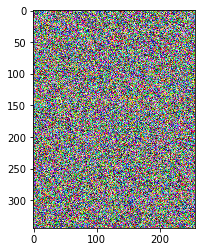

In [7]:
CONV_FILTERS = [32, 64, 128]
NUM_RESIDS = 5

from keras.layers import Input, Cropping2D
from keras.models import Model
from keras.preprocessing import image
import numpy as np
from scipy.misc import imsave
import matplotlib.pyplot as plt

input_img = image.load_img('./images/newton.jpg')
input_img = image.img_to_array(input_img)
input_img = np.expand_dims(input_img, axis=0)


# Load model
_, h, w, c = input_img.shape
inputs = Input(shape=(h, w, c))

# TODO: determine conv_filters and num_resids from weights file?
transform_net = TransformNet(inputs, CONV_FILTERS, NUM_RESIDS)

model = Model(inputs, transform_net)
model.load_weights('./models/wave_style.h5')

# Set padding/cropping border in layers
for layer in model.layers:
    padding = 8
    if isinstance(layer, ReflectionPadding2D) or isinstance(layer, Cropping2D):
        layer.padding = ((padding, padding), (padding, padding))

output_img = model.predict([input_img])[0]
plt.imshow(output_img)
plt.show()

### VGG

In [25]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Input
from keras.utils.data_utils import get_file
import keras.backend as K
import h5py
import numpy as np

WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

MEAN_PIXEL = np.array([ 123.68, 116.779, 103.939])

def vgg_layers(img_input, input_shape):
    # Block 1
    img_input = Input(tensor=img_input, shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    x = GlobalMaxPooling2D()(x)

    return x


def load_weights(model):
    weights_path = get_file('wave_style.h5',
                            WEIGHTS_PATH_NO_TOP,
                            cache_subdir='models',
                            file_hash='253f8cb515780f3b799900260a226db6')
    f = h5py.File(weights_path)
    layer_names = [name for name in f.attrs['layer_names']]

    for layer in model.layers:
        if layer.name in layer_names:
            g = f[layer.name]
            weights = [g[name] for name in g.attrs['weight_names']]
            layer.set_weights(weights)
            layer.trainable = False

    return model


def VGG19(img_input, input_shape):
    """
    VGG19, but can take input_tensor, and load weights on VGG layers only
    """
    model = Model(img_input, vgg_layers(img_input, input_shape), name='vgg19')
    model = load_weights(model)
    return model


def preprocess_input(x):
    return x - MEAN_PIXEL

### Loss Function

In [11]:
from functools import reduce

from keras.models import Model, Sequential
from keras.layers import Input
from keras import backend as K
import numpy as np
import tensorflow as tf

STYLE_LAYERS = ('block1_conv1', 'block2_conv1',
                'block3_conv1', 'block4_conv1',
                'block5_conv1')

CONTENT_LAYERS = ('block4_conv2',)

CONTENT_TRAINING_SIZE = (256, 256, 3)

def tensor_size(x):
    return np.nanprod(np.array(K.int_shape(x), dtype=np.float))

def l2_loss(x):
    return K.sum(K.square(x)) / 2

def get_vgg_features(input, layers, input_shape):
    if len(K.int_shape(input)) == 3:
        input = K.expand_dims(input, axis=0)
    input = preprocess_input(input)
    vgg = VGG19(input, input_shape)
    outputs = [layer.output for layer in vgg.layers if layer.name in layers]
    return outputs
  

def calculate_content_loss(content_image, reconstructed_image,
                           content_weight, image_shape, batch_size):
    content_features = get_vgg_features(
            content_image, CONTENT_LAYERS, image_shape)[0]
    reconstructed_content_features = get_vgg_features(
            reconstructed_image, CONTENT_LAYERS, image_shape)[0]
   
    content_size = tensor_size(content_features) * batch_size
    content_loss = content_weight * (2 * l2_loss(
        reconstructed_content_features - content_features) / content_size)
    
    return content_loss
    
def calculate_style_loss(style_image, reconstructed_image,
                         style_weight, style_image_shape, content_image_shape,
                         batch_size):
     # Get outputs of style and content images at VGG layers
    style_vgg_features = get_vgg_features(
            style_image, STYLE_LAYERS, style_image_shape)
    reconstructed_style_vgg_features = get_vgg_features(
            reconstructed_image, STYLE_LAYERS, content_image_shape)
    
    # Calculate the style features of the style image and output image
    # Style features are the gram matrices of the VGG feature maps
    style_grams = []
    style_rec_grams = []

    # Style image style features
    for features in style_vgg_features:
        _, h, w, filters = K.int_shape(features)

        # shape in K.reshape needs to be np.array to convert Dimension to int
        # (should be fixed in newer versions of Tensorflow)
        features = K.reshape(features, np.array((1, h * w, filters)))

        features_size = tensor_size(features)
        features_T = tf.transpose(features, perm=[0,2,1])
        gram = tf.matmul(features_T, features) / features_size
        style_grams.append(gram)
        
    # Output image style features
    for features in reconstructed_style_vgg_features:
        _, h, w, filters = K.int_shape(features)

        size = h * w * filters
        # Need to know batch_size ahead of time
        features = K.reshape(features, np.array((batch_size, h * w, filters)))
        features_T = tf.transpose(features, perm=[0,2,1])
        gram = tf.matmul(features_T, features) / size
        style_rec_grams.append(gram)       
        
    # Calculate style loss
    style_losses = []
    for style_gram, style_rec_gram in zip(style_grams, style_rec_grams):
        style_gram_size = tensor_size(style_gram)
        l2 = l2_loss(style_rec_gram - style_gram)
        style_losses.append(2 * l2 / style_gram_size)
    
    style_loss = style_weight * reduce(tf.add, style_losses) / batch_size
    
    return style_loss
    
    
def calculate_tv_loss(x, tv_weight, batch_size):
    tv_y_size = tensor_size(x[:,1:,:,:])
    tv_x_size = tensor_size(x[:,:,1:,:])
    y_tv = l2_loss(x[:,1:,:,:] - x[:,:CONTENT_TRAINING_SIZE[0]-1,:,:])
    x_tv = l2_loss(x[:,:,1:,:] - x[:,:,:CONTENT_TRAINING_SIZE[1]-1,:])
    tv_loss = tv_weight*2*(x_tv/tv_x_size + y_tv/tv_y_size)/batch_size
    return tv_loss


def create_loss_fn(style_image, content_weight,
                   style_weight, tv_weight, batch_size):
    style_image = tf.convert_to_tensor(style_image)

    def style_transfer_loss(y_true, y_pred):
        """
        y_true - content_image
        y_pred - reconstructed image
        """

        content_image = y_true
        reconstructed_image = y_pred
        
        content_loss = calculate_content_loss(content_image,
                                              reconstructed_image,
                                              content_weight,
                                              CONTENT_TRAINING_SIZE,
                                              batch_size)
        style_loss = calculate_style_loss(style_image,
                                          reconstructed_image,
                                          style_weight,
                                          K.int_shape(style_image),
                                          CONTENT_TRAINING_SIZE,
                                          batch_size)
        tv_loss = calculate_tv_loss(reconstructed_image, tv_weight, batch_size)

        loss = content_loss + style_loss + tv_loss
        return loss

    return style_transfer_loss

### Transform

In [12]:
from keras.layers import Conv2D, Conv2DTranspose, Input, Lambda
from keras.models import Model
import keras.layers
from keras.initializers import TruncatedNormal

from keras_contrib.layers.normalization import InstanceNormalization

WEIGHTS_INIT_STDEV = .1
INIT = TruncatedNormal(stddev=WEIGHTS_INIT_STDEV, seed=1)

def Conv2DInstanceNorm(inputs, filters, kernel_size,
                    strides=1, activation='relu'):
    return InstanceNormalization()(
            Conv2D(
                filters,
                (kernel_size, kernel_size),
                strides=strides,
                activation=activation,
                padding='same',
                kernel_initializer=INIT,
                bias_initializer=INIT
            )(inputs))

def Conv2DTransposeInstanceNorm(inputs, filters, kernel_size,
                              strides=1, activation=None):
    return InstanceNormalization()(
            Conv2DTranspose(
                filters,
                (kernel_size, kernel_size),
                strides=strides,
                activation=activation,
                padding='same',
                kernel_initializer=INIT,
                bias_initializer=INIT
            )(inputs))

def Conv2DResidualBlock(inputs):
    tmp     = Conv2DInstanceNorm(inputs, 128, 3)
    tmp2    = Conv2DInstanceNorm(tmp, 128, 3, activation=None)
    return keras.layers.add([tmp, tmp2]) 

def TransformNet(inputs):
    conv1   = Conv2DInstanceNorm(inputs, 32, 9)
    conv2   = Conv2DInstanceNorm(conv1, 64, 3, strides=2)
    conv3   = Conv2DInstanceNorm(conv2, 128, 3, strides=2)
    resid1  = Conv2DResidualBlock(conv3)
    resid2  = Conv2DResidualBlock(resid1)
    resid3  = Conv2DResidualBlock(resid2)
    resid4  = Conv2DResidualBlock(resid3)
    resid5  = Conv2DResidualBlock(resid4)
    conv_t1 = Conv2DTransposeInstanceNorm(conv3, 64, 3, strides=2)
    conv_t2 = Conv2DTransposeInstanceNorm(conv_t1, 32, 3, strides=2)
    conv_t3 = Conv2DInstanceNorm(conv_t2, 3, 9, activation='tanh')
    preds = Lambda(lambda x : x * 150 + 255./2)(conv_t3)
    return preds

### Style Transfer Training

In [ ]:
# LOCK THIS CELL
from keras.models import Model
import keras.backend as K
from keras.layers import Input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from scipy.misc import imresize
import numpy as np
import pandas as pd

CONTENT_WEIGHT = 0.5
STYLE_WEIGHT = 100
TV_WEIGHT = 200

BATCH_SIZE = 4

def create_gen(img_dir, target_size, batch_size):
    datagen = ImageDataGenerator()
    gen = datagen.flow_from_directory(img_dir, target_size=target_size,
                                      batch_size=batch_size, class_mode=None)

    def tuple_gen():
        for img in gen:
            yield (img, img)

    return tuple_gen()

style_img_path = './images/wave_style.png'
style_img = image.load_img(style_img_path)
style_target = image.img_to_array(style_img)

content_img_path = './images/netwon.jpg'
content_img = image.load_img(content_img_path)

# resize to 256x256 for training
content_img = imresize(content_img, (256, 256, 3))
content_target = image.img_to_array(content_img)

# Needed so that certain layers function in training mode (batch norm)
K.set_learning_phase(1)

inputs = Input(shape=(256, 256, 3))
transform_net = TransformNet(inputs)
model = Model(inputs=inputs, outputs=transform_net)
loss_fn = create_loss_fn(style_target, CONTENT_WEIGHT,
                         STYLE_WEIGHT, TV_WEIGHT, BATCH_SIZE)
model.compile(optimizer='adam', loss=loss_fn)

gen = create_gen('data', target_size=(256, 256), batch_size=BATCH_SIZE)
history = model.fit_generator(gen, steps_per_epoch=82780)
model.save('wave_style.h5')
pd.DataFrame(history.history).to_csv('wave_style.csv')

### Evaluate

In [26]:
import keras
import numpy as np
from keras.models import load_model
from keras.preprocessing import image
from keras_contrib.layers.normalization import InstanceNormalization
from scipy.misc import imresize

CONTENT_WEIGHT = 0.5
STYLE_WEIGHT = 100
TV_WEIGHT = 200

BATCH_SIZE = 4

style_img_path = './images/wave_style.png'
style_img = image.load_img(style_img_path)
style_target = image.img_to_array(style_img)

loss_fn = create_loss_fn(style_target, CONTENT_WEIGHT,
                         STYLE_WEIGHT, TV_WEIGHT, BATCH_SIZE)

model = load_model('models/wave_style.h5', custom_objects={
    'InstanceNormalization': InstanceNormalization,
    'style_transfer_loss': loss_fn
})
model.summary()

KeyError: "Can't open attribute (Can't locate attribute: 'layer_names')"

In [ ]:
import matplotlib.pyplot as plt
# Get output
content_img_path = './images/newton.jpg'
content_img = image.load_img(content_img_path)

content_img = imresize(content_img, (256, 256, 3))
content_target = image.img_to_array(content_img)
content_target = np.expand_dims(content_target, axis=0)


output = model.predict([content_target])[0]
plt.imshow(output)
plt.show()